# <font  color='red'><center>Reconnaissance des lettres arabes manuscrites avec k-means</center></font>


## Préparation des données

In [2]:
from PIL import Image
import numpy as np
import os

# Créer une liste vide pour stocker les données d'images
X = []

# Créer une liste vide pour stocker les labels des images
y = []

# Parcourir tous les sous-dossiers de 'images'
for root, dirs, files in os.walk('letters_arabic'):
    # Récupérer le titre du sous-dossier (c'est-à-dire le label de chaque image)
    label = os.path.basename(root)
    
    # Pour chaque fichier d'image dans le sous-dossier
    for file in files:
        # Charger l'image en mémoire
        img = Image.open(os.path.join(root, file))
        image_grayscale = img.convert('L')

        # Convertir l'image en tableau NumPy en utilisant np.array()
        image_array = np.array(image_grayscale)
        # Convertir l'image en tableau NumPy et l'ajouter à la liste des données d'images
        X.append(image_array)
        
        # Ajouter le label à la liste des labels des images
        y.append(label)


### Mélange d'ensemble de données

In [7]:
import random

# Créez une liste d'index qui correspond aux éléments de la liste
indexes = list(range(len(X)))

# Mélangez la liste d'index
random.shuffle(indexes)

# Mélangez les éléments de la liste en utilisant la liste d'index mélangée
X = [X[i] for i in indexes]
y = [y[i] for i in indexes]

## Visualisation de quelques images


<ipython-input-8-e5aa11f53799>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


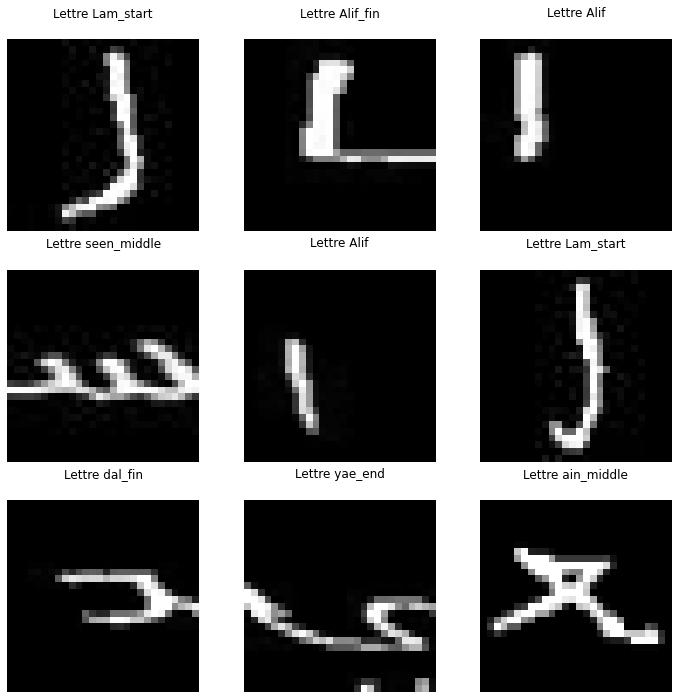

In [8]:
import matplotlib.pyplot as plt

# create figure with 3x3 subplots using matplotlib.pyplot
fig, axs = plt.subplots(3, 3, figsize = (12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.matshow(X[i])
    ax.axis('off')
    ax.set_title('Lettre {}'.format(y[i]))
    
# display the figure
fig.show()


## Prétraitement des données

#### Encodage de la variable catégorielle y

In [9]:
# Créer un dictionnaire qui associe chaque valeur catégorique à un entier unique
value_to_int = {value: i for i, value in enumerate(set(y))}

# Afficher le dictionnaire
print(value_to_int)

# Encoder les données catégorielles à l'aide du dictionnaire
Y_encoded = [value_to_int[y] for y in y]

# Afficher les données encodées
print(Y_encoded)

{'Alif_maqsora': 0, 'khae': 1, 'Mim_middle': 2, 'sheen_middle': 3, 'ain_end': 4, 'seen_start': 5, 'Lam_end': 6, 'Hhae_middle': 7, 'waw_end': 8, 'Mim': 9, 'Lam_start': 10, 'Hae_start': 11, 'rae_fin': 12, 'yae_end': 13, 'ain': 14, 'seen_middle': 15, 'tae_marbouta': 16, 'Noun_start': 17, 'zae': 18, 'ain_start': 19, 'Ta': 20, 'Noun_middle': 21, 'ghain': 22, 'Hamza': 23, 'Alif': 24, 'rae': 25, 'bae_start': 26, 'jeem': 27, 'waw': 28, 'sheen_start': 29, 'Lam_middle': 30, 'yae_start': 31, 'ain_middle': 32, 'Hhae_start': 33, 'Alif_fin': 34, 'Kaf_start': 35, 'Lam_alif': 36, 'seen': 37, 'Noun': 38, 'yae_middle': 39, 'Quaf': 40, 'dal': 41, 'bae': 42, 'dad_start': 43, 'tae': 44, 'Mim_start': 45, 'sad_start': 46, 'dal_fin': 47, 'Fae': 48, 'Kaf_middle': 49}
[10, 34, 24, 15, 24, 10, 47, 13, 32, 10, 13, 5, 7, 3, 10, 7, 26, 24, 19, 11, 45, 24, 31, 7, 45, 12, 38, 2, 34, 24, 34, 45, 35, 27, 19, 30, 34, 2, 23, 26, 16, 2, 29, 14, 10, 5, 24, 10, 24, 12, 36, 9, 39, 11, 27, 33, 47, 19, 21, 20, 15, 10, 42, 39, 

In [11]:
# Convertir les listes en tableaux NumPy
X = np.array(X)
Y= np.array(Y_encoded)

#Conversion de chaque image en tableau de 1-dimension
X = X.reshape(len(X),-1)

# normalisation des données de 0-1 
X = X.astype(float) / 255.


numpy.ndarray

## Entrainement du modèle K-means

Étant donné que la taille de l'ensemble de données MNIST est assez importante, nous utiliserons l'implémentation en mini-batch du classification k-means (MiniBatchKMeans) fourni par scikit-learn. Cela réduira considérablement le temps nécessaire pour adapter l'algorithme aux données.


In [13]:
from sklearn.cluster import MiniBatchKMeans

n_digits = len(np.unique(Y))
print(n_digits)

# Initialisation du modèle 
kmeans = MiniBatchKMeans(n_clusters = n_digits,batch_size = 1024)

# Ajuster le modèle aux données d'entrainement
kmeans.fit(X)

50


MiniBatchKMeans(n_clusters=50)

In [14]:
#Etiquette de chaque entrée généré par k-means
print(kmeans.labels_)
len(kmeans.labels_)

[ 8  4 31 ... 40 37 16]


7143

## Affectation de l'étiquette réelle


Le clustering K-means est une méthode d'apprentissage automatique non supervisée. par conséquent, les étiquettes attribuées par notre algorithme KMeans font référence au identifiant du cluster auquel chaque tableau a été attribué, et non à l'entier cible réel.

In [15]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associe l'étiquette la plus probable à chaque cluster dans le modèle KMeans
    renvoie : dictionnaire des clusters attribués à chaque étiquette
    """
    # variable contient les étiquettes déduit
    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # iterer sur chaque cluster et trouver les indices de chaque cluster 
        # l'objectif c'est grouper les elements de chaque cluster 
        labels = []
        index = np.where(kmeans.labels_ == i)

        # associer l'étiquettes réelles pour chaque point du cluster
        labels.append(actual_labels[index])

        # déterminer l'étiquette la plus fréquente
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # affecter le cluster à une valeur dans le dictionnaire des étiquettes déduit
        if np.argmax(counts) in inferred_labels:
            # ajouter le nouveau numéro au tableau existant à cet emplacement
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # créer un nouveau tableau dans cet emplacement
            inferred_labels[np.argmax(counts)] = [i]
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Détermine l'étiquette de chaque tableau , en fonction du cluster auquel elle a été attribuée.
    renvoie : étiquettes prédites pour chaque tableau
    """
    
    # tableau vide remplie par des zero
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels


## Evaluation du modèle

In [16]:
from sklearn.metrics import homogeneity_score

def calc_metrics(estimator, data, labels):
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    # Inertie
    inertia = estimator.inertia_
    print("Inertia: {}".format(inertia))
    # Score d'homogeneity 
    homogeneity = homogeneity_score(labels, estimator.labels_)
    print("Homogeneity score: {}".format(homogeneity))
    return inertia, homogeneity

In [27]:
from sklearn.metrics import accuracy_score

clusters = [50, 90, 150, 200, 310, 430]
iner_list = []
homo_list = []
acc_list = []

for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters=n_clusters,batch_size = 1024)
    estimator.fit(X)
    
    inertia, homo = calc_metrics(estimator, X, Y)
    iner_list.append(inertia)
    homo_list.append(homo)
    
    # Determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, Y)
    prediction = infer_data_labels(estimator.labels_, cluster_labels)
    
    acc = accuracy_score(Y, prediction)
    acc_list.append(acc)
    print('Accuracy: {}\n'.format(acc))

Number of Clusters: 50
Inertia: 260649.31558900804
Homogeneity score: 0.29689648593686435
Accuracy: 0.2623547529049419

Number of Clusters: 90
Inertia: 245602.4598271668
Homogeneity score: 0.35754069969468466
Accuracy: 0.3033739325213496

Number of Clusters: 150
Inertia: 230860.08408721606
Homogeneity score: 0.4062769644473089
Accuracy: 0.34229315413691724

Number of Clusters: 200
Inertia: 224004.67827118153
Homogeneity score: 0.4359256928296782
Accuracy: 0.3620327593448131

Number of Clusters: 310
Inertia: 213326.96220943378
Homogeneity score: 0.47186291515617185
Accuracy: 0.3858322833543329

Number of Clusters: 430
Inertia: 200938.77688006865
Homogeneity score: 0.5063813899352138
Accuracy: 0.4139717205655887



## Implémentation du modèle avec n_clusters=430

In [33]:
kmeans = MiniBatchKMeans(n_clusters=430,batch_size = 1024)
kmeans.fit(X)

cluster_labels = infer_cluster_labels(kmeans, Y)

test_clusters = kmeans.predict(X)
prediction = infer_data_labels(kmeans.predict(X), cluster_labels)
print('Accuracy: {}'.format(accuracy_score(Y, prediction)))

Accuracy: 0.4150916981660367


### Visualisation des images réelles

In [30]:
import matplotlib.pyplot as plt

%matplotlib inline
kmeans = MiniBatchKMeans(n_clusters = 430,batch_size = 1024)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(430, 28, 28)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)
prediction = infer_data_labels(kmeans.predict(X), cluster_labels)



In [31]:
# Create a dictionary that maps each integer value to the original categorical value
dict = {i: value for value, i in value_to_int.items()}

type(dict)

dict

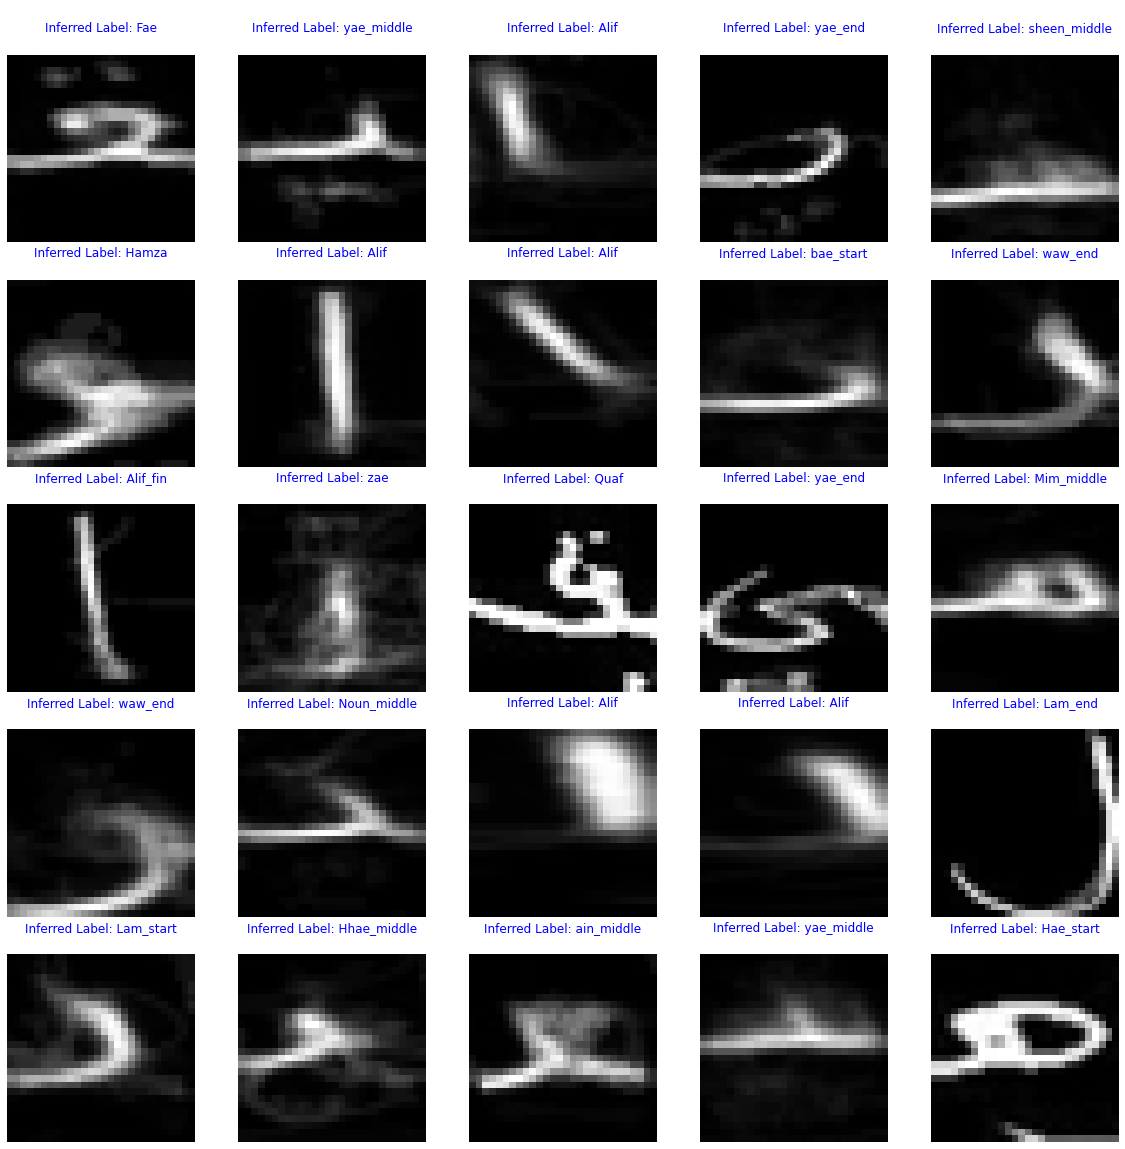

In [32]:
# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(5, 5, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():        
        if i in value:
            ax.set_title('\nInferred Label: {}'.format(dict[key]), color='blue')
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
plt.show()

## <font  color='red'> Amélioration du modèle avec ACP</font>


In [34]:
from PIL import Image
import numpy as np
import os

# Créer une liste vide pour stocker les données d'images
X = []

# Créer une liste vide pour stocker les labels des images
y = []

# Parcourir tous les sous-dossiers de 'images'
for root, dirs, files in os.walk('letters_arabic'):
    # Récupérer le titre du sous-dossier (c'est-à-dire le label de chaque image)
    label = os.path.basename(root)
    
    # Pour chaque fichier d'image dans le sous-dossier
    for file in files:
        # Charger l'image en mémoire
        img = Image.open(os.path.join(root, file))
        image_grayscale = img.convert('L')

        # Convertir l'image en tableau NumPy en utilisant np.array()
        image_array = np.array(image_grayscale)
        # Convertir l'image en tableau NumPy et l'ajouter à la liste des données d'images
        X.append(image_array)
        
        # Ajouter le label à la liste des labels des images
        y.append(label)


In [35]:
import random


# Créez une liste d'index qui correspond aux éléments de la liste
indexes = list(range(len(X)))

# Mélangez la liste d'index
random.shuffle(indexes)

# Mélangez les éléments de la liste en utilisant la liste d'index mélangée
X = [X[i] for i in indexes]
y = [y[i] for i in indexes]

In [37]:
# Create a dictionary that maps each categorical value to a unique integer
value_to_int = {value: i for i, value in enumerate(set(y))}

# Encode the categorical data using the dictionary
Y_encoded = [value_to_int[y] for y in y]


In [38]:
# Convertir les listes en tableaux NumPy
X = np.array(X)
Y= np.array(Y_encoded)

#Conversion de chaque image en tableau de 1-dimension
X = X.reshape(len(X),-1)

# normalisation des données de 0-1 
X = X.astype(float) / 255.


In [39]:
# Normaliser les données 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Supprimer le bruit de données
from sklearn.decomposition import PCA
pca = PCA(n_components=100, random_state=123)
X = pca.fit_transform(X)


In [40]:
from sklearn.cluster import MiniBatchKMeans

n_digits = len(np.unique(Y))
print(n_digits)

# Initialisation du modèle 
kmeans = MiniBatchKMeans(n_clusters = n_digits,batch_size = 1024)

# Ajuster le modèle aux données d'entrainement
kmeans.fit(X)

50


MiniBatchKMeans(n_clusters=50)

In [41]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associe l'étiquette la plus probable à chaque cluster dans le modèle KMeans
    renvoie : dictionnaire des clusters attribués à chaque étiquette
    """
    # variable contient les étiquettes déduit
    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # iterer sur chaque cluster et trouver les indices de chaque cluster 
        # l'objectif c'est grouper les elements de chaque cluster 
        labels = []
        index = np.where(kmeans.labels_ == i)

        # associer l'étiquettes réelles pour chaque point du cluster
        labels.append(actual_labels[index])

        # déterminer l'étiquette la plus fréquente
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # affecter le cluster à une valeur dans le dictionnaire des étiquettes déduit
        if np.argmax(counts) in inferred_labels:
            # ajouter le nouveau numéro au tableau existant à cet emplacement
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # créer un nouveau tableau dans cet emplacement
            inferred_labels[np.argmax(counts)] = [i]
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Détermine l'étiquette de chaque tableau , en fonction du cluster auquel elle a été attribuée.
    renvoie : étiquettes prédites pour chaque tableau
    """
    
    # tableau vide remplie par des zero
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels


In [42]:
from sklearn.metrics import homogeneity_score

def calc_metrics(estimator, data, labels):
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    # Inertie
    inertia = estimator.inertia_
    print("Inertia: {}".format(inertia))
    # Score d'homogeneity 
    homogeneity = homogeneity_score(labels, estimator.labels_)
    print("Homogeneity score: {}".format(homogeneity))
    return inertia, homogeneity

In [45]:
from sklearn.metrics import accuracy_score

clusters = [50, 150, 250, 430, 560,640]
iner_list = []
homo_list = []
acc_list = []

for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters=n_clusters,batch_size = 1024)
    estimator.fit(X)
    
    inertia, homo = calc_metrics(estimator, X, Y)
    iner_list.append(inertia)
    homo_list.append(homo)
    
    # Determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, Y)
    prediction = infer_data_labels(estimator.labels_, cluster_labels)
    
    acc = accuracy_score(Y, prediction)
    acc_list.append(acc)
    print('Accuracy: {}\n'.format(acc))

Number of Clusters: 50
Inertia: 2828185.6486146194
Homogeneity score: 0.2820353006911082
Accuracy: 0.23883522329553408

Number of Clusters: 150
Inertia: 2359941.3563515544
Homogeneity score: 0.39935733412066743
Accuracy: 0.3226935461290774

Number of Clusters: 250
Inertia: 2128094.4035609136
Homogeneity score: 0.467455026043361
Accuracy: 0.374212515749685

Number of Clusters: 430
Inertia: 1894949.6872990262
Homogeneity score: 0.5341783046307594
Accuracy: 0.4239115217695646

Number of Clusters: 560
Inertia: 1813373.0668932726
Homogeneity score: 0.5671959817684713
Accuracy: 0.4465910681786364

Number of Clusters: 640
Inertia: 1696262.2988369693
Homogeneity score: 0.5950021848061436
Accuracy: 0.4747305053898922



In [61]:
kmeans = MiniBatchKMeans(n_clusters=640,batch_size = 1024)
kmeans.fit(X)

cluster_labels = infer_cluster_labels(kmeans, Y)

test_clusters = kmeans.predict(X)
prediction = infer_data_labels(kmeans.predict(X), cluster_labels)
print('Accuracy: {}'.format(accuracy_score(Y, prediction)))

Accuracy: 0.4643707125857483
